In [4]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def collect_data_and_plot(df, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{row['# of stores']}/{row['Architecture Class']}/{underage_cost}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 32768
        batch_size = 4096
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = row['# of stores']
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() * n_stores + relevant_data['s_holding_costs'].sum() * n_stores + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate min cost for each number of stores
    df['cost'] = df.groupby('# of stores')['avg_cost'].transform(lambda x: x/x.min() * 100)

    plot_data = df.pivot(index="# of stores", columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum at each # of stores)', 'Average Store lost sales / (average unit underage cost)', 'Average Store Holding Cost / (average unit underage cost)', 'Average Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    x_values = df['# of stores'].unique()
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Number of stores')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


In [5]:
# Create vanilla results dataframe from the provided data
vanilla_data = []
for n_stores in [3, 5, 10]:
    for lead_time in [2, 6]:
        for underage_cost in [4, 9]:
            for correlation in [0.0, 0.5]:
                # Find matching row in provided data
                row = {
                    '# of stores': n_stores,
                    'store_lead_time': lead_time, 
                    'store_underage_cost': underage_cost,
                    'stores_correlation': correlation,
                    'Architecture Class': 'paper_result',
                    'Test Loss': None
                }
                # Match with provided data and set test loss
                if n_stores == 3 and lead_time == 2 and underage_cost == 4 and correlation == 0.0:
                    row['Test Loss'] = 3.30
                elif n_stores == 3 and lead_time == 2 and underage_cost == 4 and correlation == 0.5:
                    row['Test Loss'] = 3.69
                elif n_stores == 3 and lead_time == 2 and underage_cost == 9 and correlation == 0.0:
                    row['Test Loss'] = 4.14
                elif n_stores == 3 and lead_time == 2 and underage_cost == 9 and correlation == 0.5:
                    row['Test Loss'] = 4.63
                elif n_stores == 3 and lead_time == 6 and underage_cost == 4 and correlation == 0.0:
                    row['Test Loss'] = 4.66
                elif n_stores == 3 and lead_time == 6 and underage_cost == 4 and correlation == 0.5:
                    row['Test Loss'] = 4.95
                elif n_stores == 3 and lead_time == 6 and underage_cost == 9 and correlation == 0.0:
                    row['Test Loss'] = 5.85
                elif n_stores == 3 and lead_time == 6 and underage_cost == 9 and correlation == 0.5:
                    row['Test Loss'] = 6.20
                elif n_stores == 5 and lead_time == 2 and underage_cost == 4 and correlation == 0.0:
                    row['Test Loss'] = 2.94
                elif n_stores == 5 and lead_time == 2 and underage_cost == 4 and correlation == 0.5:
                    row['Test Loss'] = 3.39
                elif n_stores == 5 and lead_time == 2 and underage_cost == 9 and correlation == 0.0:
                    row['Test Loss'] = 3.69
                elif n_stores == 5 and lead_time == 2 and underage_cost == 9 and correlation == 0.5:
                    row['Test Loss'] = 4.25
                elif n_stores == 5 and lead_time == 6 and underage_cost == 4 and correlation == 0.0:
                    row['Test Loss'] = 4.27
                elif n_stores == 5 and lead_time == 6 and underage_cost == 4 and correlation == 0.5:
                    row['Test Loss'] = 4.59
                elif n_stores == 5 and lead_time == 6 and underage_cost == 9 and correlation == 0.0:
                    row['Test Loss'] = 5.36
                elif n_stores == 5 and lead_time == 6 and underage_cost == 9 and correlation == 0.5:
                    row['Test Loss'] = 5.76
                elif n_stores == 10 and lead_time == 2 and underage_cost == 4 and correlation == 0.0:
                    row['Test Loss'] = 3.00
                elif n_stores == 10 and lead_time == 2 and underage_cost == 4 and correlation == 0.5:
                    row['Test Loss'] = 3.55
                elif n_stores == 10 and lead_time == 2 and underage_cost == 9 and correlation == 0.0:
                    row['Test Loss'] = 3.76
                elif n_stores == 10 and lead_time == 2 and underage_cost == 9 and correlation == 0.5:
                    row['Test Loss'] = 4.45
                elif n_stores == 10 and lead_time == 6 and underage_cost == 4 and correlation == 0.0:
                    row['Test Loss'] = 4.45
                elif n_stores == 10 and lead_time == 6 and underage_cost == 4 and correlation == 0.5:
                    row['Test Loss'] = 4.84
                elif n_stores == 10 and lead_time == 6 and underage_cost == 9 and correlation == 0.0:
                    row['Test Loss'] = 5.58
                elif n_stores == 10 and lead_time == 6 and underage_cost == 9 and correlation == 0.5:
                    row['Test Loss'] = 6.08
                vanilla_data.append(row)

vanilla_df = pd.DataFrame(vanilla_data)


Statistics by Parameter Combination:
 # of stores  store_lead_time  store_underage_cost  stores_correlation                   Architecture Class  Test Loss  Learning Rate  Train Loss  Dev Loss  Test Gap %  Mean Test Loss  Test Loss Variance
           3                2                    4                 0.0 GNN_MP_transshipment_merged_residual   3.555093         0.0010    3.561975  3.558668    7.730084        4.352154        1.270612e+00
           3                2                    4                 0.0                         paper_result   3.300000            NaN         NaN       NaN    0.000000        3.300000                 NaN
           5                2                    4                 0.0 GNN_MP_transshipment_merged_residual   4.215537         0.0001    4.223528  4.213709   43.385599      423.952612        3.523584e+05
           5                2                    4                 0.0                         paper_result   2.940000            NaN         NaN 

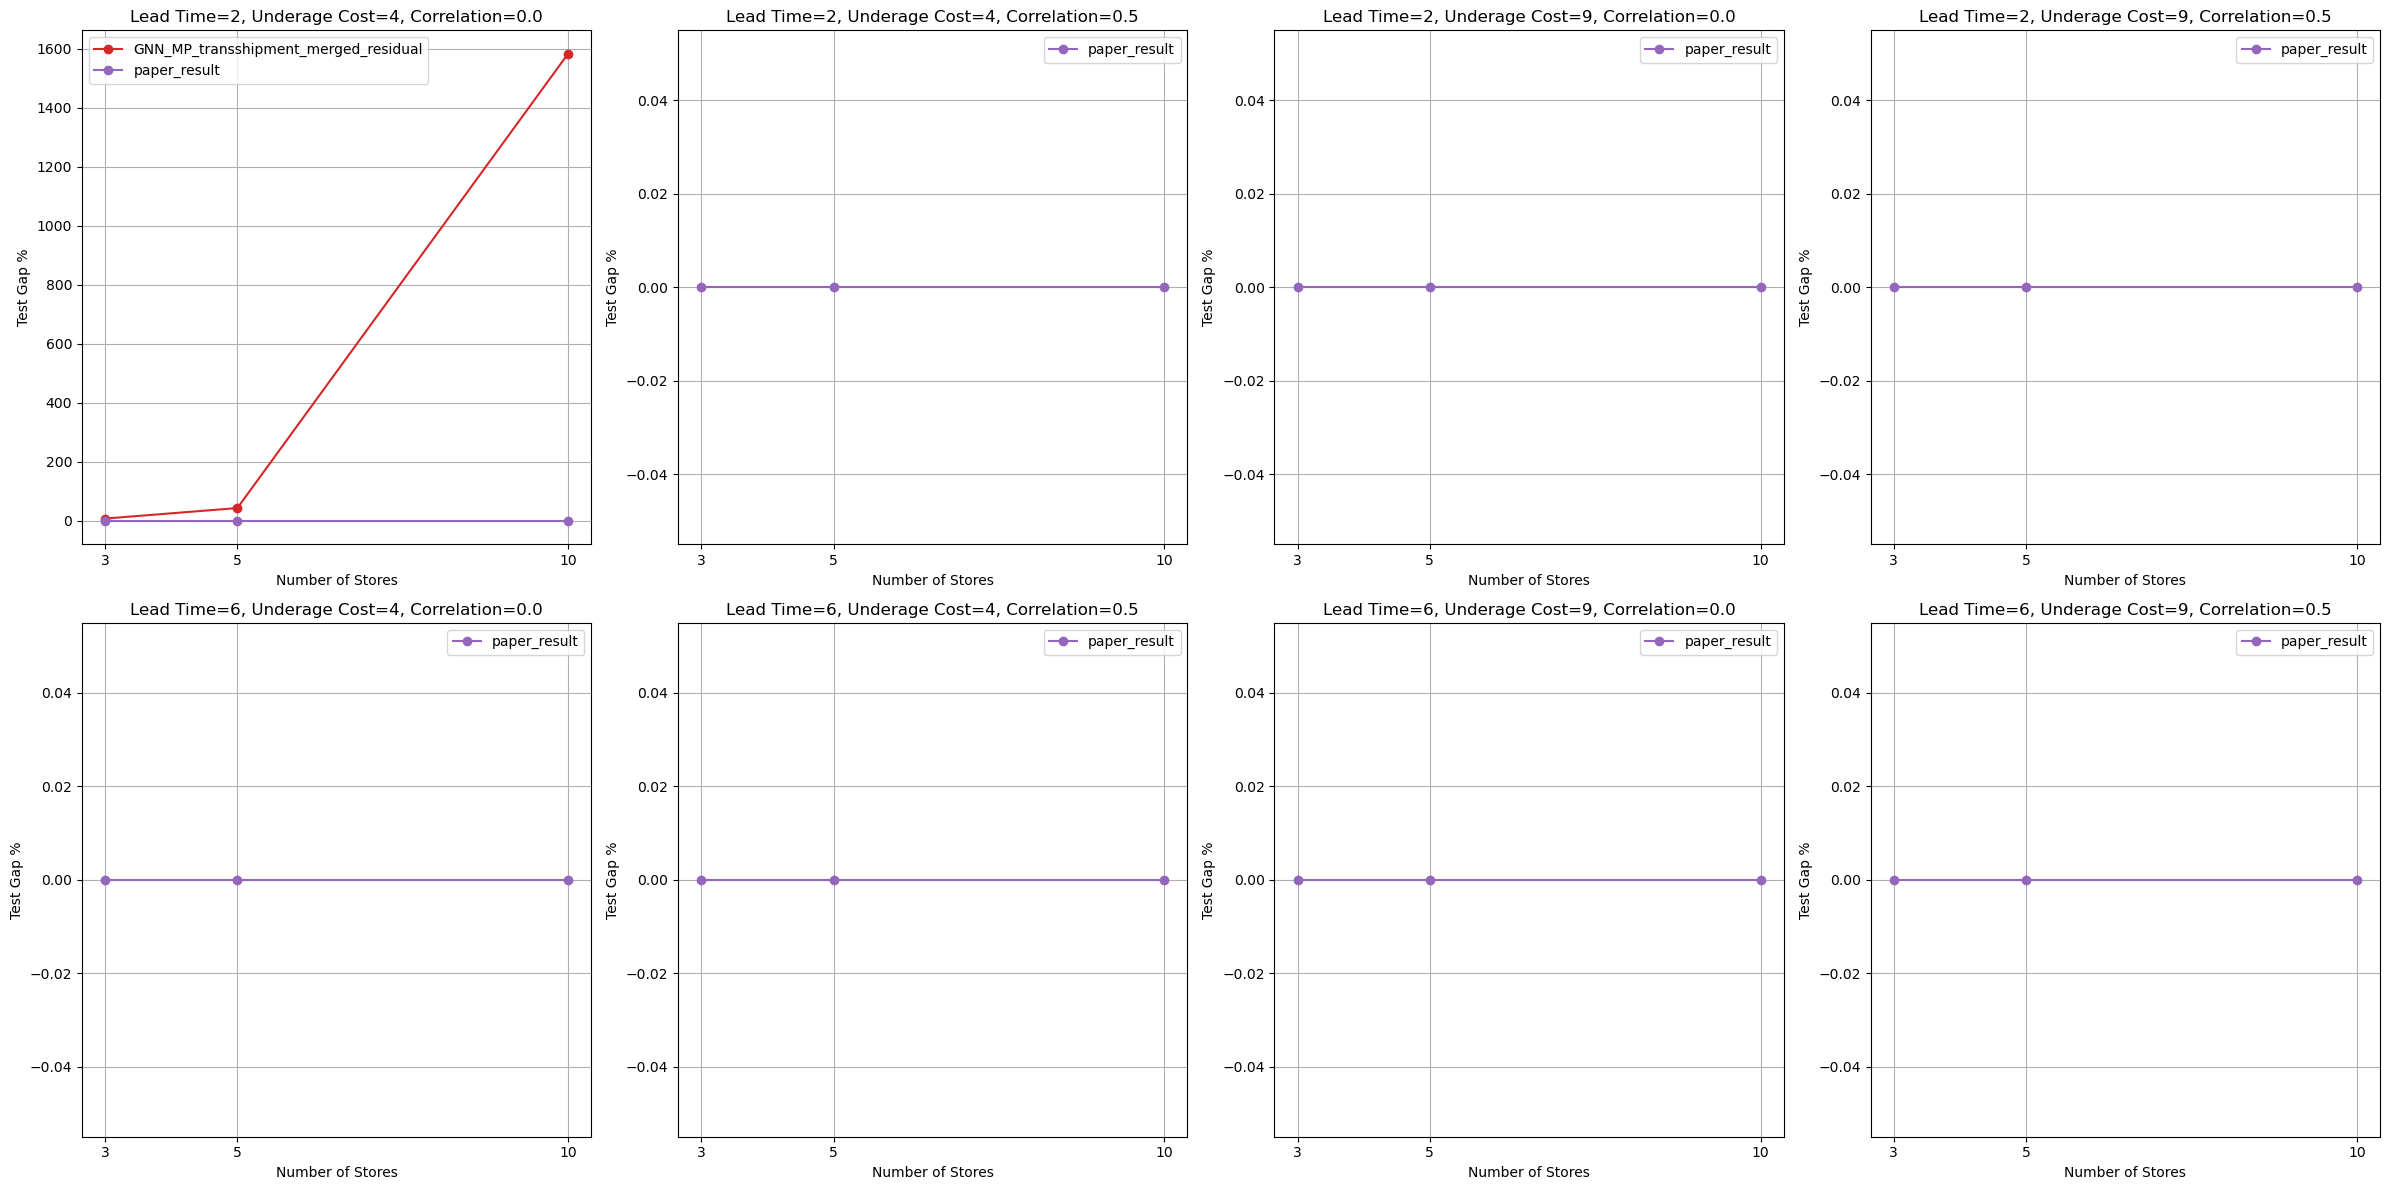

In [9]:
# Define color scheme for architecture types
color_scheme = {
    "GNN_MP_transshipment": "#ff7f0e",  # Orange
    "GNN_MP_NN_Per_Layer_transshipment": "#2ca02c",  # Green
    "GNN_MP_transshipment_merged": "#1f77b4",  # Blue
    "GNN_MP_transshipment_merged_residual": "#d62728",  # Red
    "paper_result": "#9467bd",  # Purple
}

linestyle_scheme = {
    "GNN_MP_transshipment": "-",  # Solid
    "GNN_MP_NN_Per_Layer_transshipment": "-",  # Solid
    "GNN_MP_transshipment_merged": "-",  # Solid
    "GNN_MP_transshipment_merged_residual": "-",  # Solid
    "paper_result": "-",  # Solid
}

testset_name = "generic_architecture_transshipment"

# Define paths for each architecture
architectures = {
    "GNN_MP_transshipment_merged_residual": {}
}

for arch in architectures:
    architectures[arch] = {
        n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/{arch}/{n_stores}'
        for n_stores in [3, 5, 10]
    }
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'
results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
dfs = []
params = {
    'store_lead_time': [2, 6],
    'store_underage_cost': [4, 9], 
    'stores_correlation': [0.0, 0.5]
}
dfs.append(vanilla_df)

for arch_name, paths in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            for correlation in params['stores_correlation']:
                df = results_interpretor.make_table(paths,
                    {'store_lead_time': lead_time,
                     'store_underage_cost': underage_cost,
                     'stores_correlation': correlation,
                     'samples': [1,2,3]},
                    default_condition_setter, custom_data_filler, 
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
                if df.empty:
                    continue
                
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['store_lead_time'] = lead_time
                df['store_underage_cost'] = underage_cost
                df['stores_correlation'] = correlation
                dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage for each parameter combination
# Calculate min test loss per parameter group
min_test_loss = df.groupby(['# of stores', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100

# Calculate mean and variance statistics grouped by parameters and architecture
grouped_stats = df.groupby(['# of stores', 'Architecture Class', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss']
df['Mean Test Loss'] = grouped_stats.transform('mean').round(6)
df['Test Loss Variance'] = grouped_stats.transform('var').round(6)

# Keep only the row with lowest mean test loss for each setting
df = df.loc[df.groupby(['# of stores', 'Architecture Class', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss'].idxmin()]

# Create subplots for each parameter combination
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

param_combinations = []
for lt in params['store_lead_time']:
    for uc in params['store_underage_cost']:
        for corr in params['stores_correlation']:
            param_combinations.append((lt, uc, corr))

for idx, (lt, uc, corr) in enumerate(param_combinations):
    data = df[(df['store_lead_time'] == lt) & 
              (df['store_underage_cost'] == uc) &
              (df['stores_correlation'] == corr)]
    
    pivot_df = data.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()
    
    for arch in pivot_df.columns:
        axes[idx].plot(pivot_df.index.to_numpy(), pivot_df[arch].to_numpy(),
                marker='o', label=arch,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch])
    axes[idx].set_title(f'Lead Time={lt}, Underage Cost={uc}, Correlation={corr}')
    axes[idx].set_xlabel('Number of Stores')
    axes[idx].set_ylabel('Test Gap %')
    axes[idx].grid(True)
    axes[idx].legend()
    axes[idx].set_xticks([3, 5, 10])

print("\nStatistics by Parameter Combination:")

# Drop specified columns
df = df.drop(['# of runs', 'samples', 'hyperparam_name', 'path'], axis=1)

print(df.sort_values(['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores']).to_string(index=False))

plt.tight_layout()
plt.show()

In [17]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand_exp_underage_cost_random_yield", 1)